# What is an Ormsby wavelet?

Let's try to reproduce an Ormsby wavelet (aka trapezoidal spectrum wavelet). This is a low-cut / low-pass / high-pass / high-cut filter.

The original reference is Ormsby, J (1961). Design of numerical filters with applications to missile data processing. Journal of the ACM 8 (3), p 440–466. https://doi.org/10.1145/321075.321087

The paper most people seem to reference is [Ryan 1994](https://csegrecorder.com/articles/view/ricker-ormsby-klander-butterworth-a-choice-of-wavelets), Ricker, Ormsby, Klander, Butterworth – A Choice of Wavelets, CSEG Recorder, vol 19, no 07.

It contains this figure:

<img src="Ormsby_wavelet.jpg" />

I take this to be the correct wavelet.

## `bruges` time domain

If you don't already have [`bruges`](https://bruges.readthedocs.io/), you may need to 

    pip install bruges

installing it into your Python environment, and then re-open this notebook.

https://github.com/agile-geoscience/bruges

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Make a set of points corresponding to an Ormsby bandpass filter

In [2]:
from bruges.filters import ormsby

Bruges has an analytic time-domain function for creating an Ormsby wavelet. It was coded from the equation in [Ryan 1994](https://csegrecorder.com/articles/view/ricker-ormsby-klander-butterworth-a-choice-of-wavelets).

We need to pass in the the <code>duration</code>, the sample rate <code>dt</code> and the four bandpass frequencies, <code>freqs</code> as a list.

In [3]:
freqs = [5, 10, 40, 45]

orms, tw = ormsby(0.4, dt=0.004, f=freqs, return_t=True, sym=True)

Let's plot the Ormsby wavelet in the time domain.

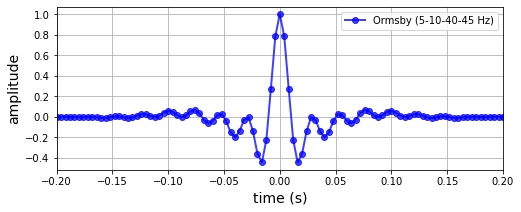

In [4]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(tw, orms, 'bo-', lw=2, alpha=0.75, 
        label='Ormsby ({}-{}-{}-{} Hz)'.format(*freqs))
ax.legend(loc=1)
ax.set_xlim(-0.2,0.2)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.grid()

plt.show()

This matches the figure in Ryan 1994:

In [5]:
from scipy.interpolate import interp1d

def smoothify(t, w):
    func = interp1d(t, w, kind='cubic')
    tnew = np.linspace(t.min(), t.max(), 1000)
    return tnew, func(tnew)

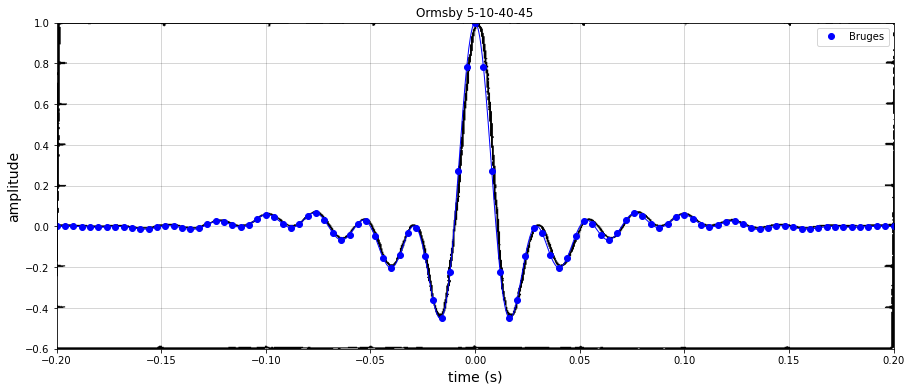

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))

# Show the background plot.
img = plt.imread('Ormsby_wavelet_data-area.png')
ax.imshow(img, extent=[-0.2, 0.2, -0.6, 1.0], aspect='auto')

# Plot the smoothed waveforms.
ax.plot(*smoothify(tw, orms), 'b', lw=1)

# Plot the points we computed.
ax.plot(tw, orms, 'bo', label='Bruges')

# Trimmings.
ax.legend(loc=1)
ax.set_xlim(-0.2,0.2)
ax.set_ylim(-0.6, 1.0)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_title("Ormsby {}-{}-{}-{}".format(*freqs))
ax.grid(c='k', alpha=0.2)

plt.show()

## New `bruges` FFT implementation

You will need `bruges` version 0.4.2 for this.

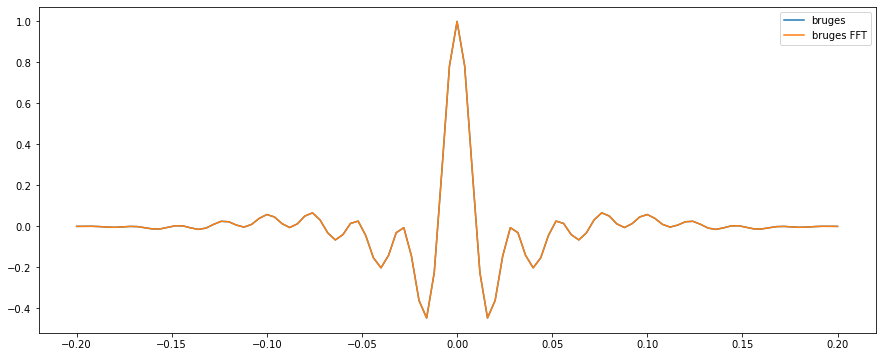

In [7]:
from bruges.filters import ormsby_fft

orms_fft, tw_fft = ormsby_fft(0.4, dt=0.004, f=freqs)

plt.figure(figsize=(15, 6))
plt.plot(tw, orms, label='bruges')
plt.plot(tw_fft, orms_fft, label='bruges FFT')
plt.legend()

The advantage of the FFT method is that we can change the amount of energy going into the low vs the high frequencies. For example, this Ormsby is 'pink' — it has more low-frequency energy than high.

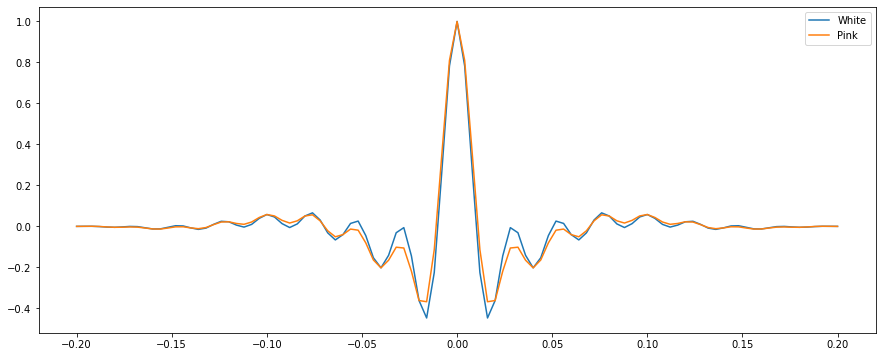

In [8]:
orms_pink, _ = ormsby_fft(0.4, dt=0.004, f=freqs, P=(0, -5))

plt.figure(figsize=(15, 6))
plt.plot(tw_fft, orms_fft, label='White')
plt.plot(tw_fft, orms_pink, label='Pink')
plt.legend()

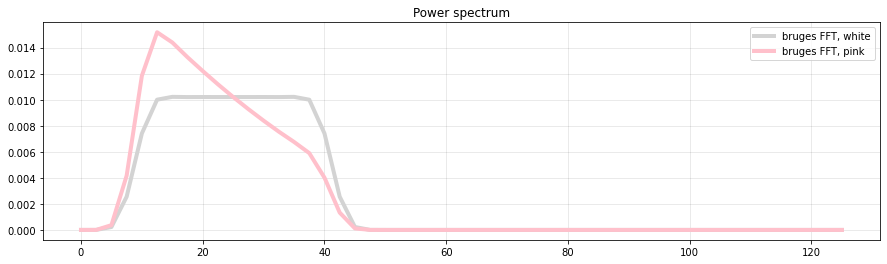

In [9]:
from scipy.signal import welch

plt.figure(figsize=(15, 4))

plt.plot(*welch(orms_fft, fs=250, nperseg=100, scaling='spectrum'), c='lightgray', lw=4, label='bruges FFT, white')
plt.plot(*welch(orms_pink, fs=250, nperseg=100, scaling='spectrum'), c='pink', lw=4, label='bruges FFT, pink')
plt.legend()
plt.grid(c='k', alpha=0.1)
plt.title('Power spectrum')
plt.show()

## OpenGeo Solutions

This is from their web app, https://www.opengeosolutions.com/technologies/blockfiltertech

Using parameters: 5-10-40-45, 0% taper, 0-400 ms.

In [10]:
import pandas as pd

url = "https://raw.githubusercontent.com/softwareunderground/repro-zoo/master/ryan-1994/Traces_20210209_193429.csv"
df = pd.read_csv(url)

df.head()

,Ormsby Filter: 5-10-40-45(Hz),Time (ms),AI Model Trace,AI Filtered Trace,RC Model Trace,RC Filtered Trace,Impulse Trace,Filter Impulse Response,DFT Window
0,,-13.0,1,-0.002612,0.0,0.000779,0,-0.000046,0
1,,-9.0,1,-0.001801,0.0,0.000564,0,-0.000848,0
2,,-5.0,1,-0.001445,0.0,0.000076,0,-0.001554,0
3,,-1.0,1,-0.001502,0.0,-0.000092,0,-0.001294,0
4,,3.0,1,-0.001479,0.0,0.000179,0,-0.000387,1


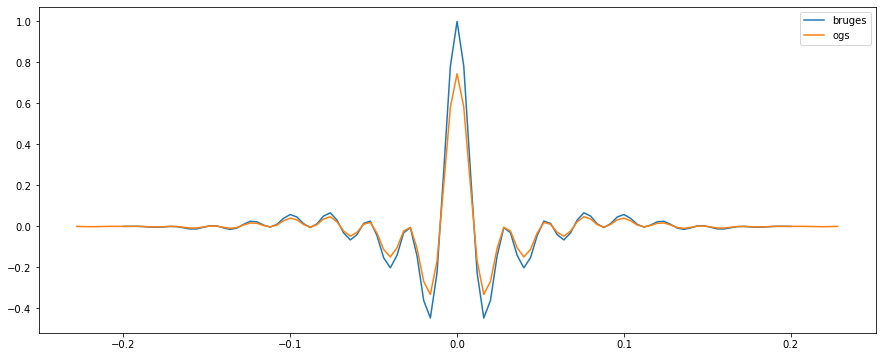

In [11]:
tw1 = df['Time (ms)'] / 1000 - 0.215  # This is weird.
orms1 = df['Filter Impulse Response']

plt.figure(figsize=(15, 6))
plt.plot(tw, orms, label='bruges')
plt.plot(tw1, orms1, label='ogs')
plt.legend()

Seems like they are applying some sort of taper.

## Ryan 1994, and SEG Wiki

This is the one given in Ryan 1994. It seems like there's an 'extra' `np.pi` in the `sinc` function — I originally thought this was an error, but it turns out that NumPy's `sinc()` just includes this $\pi$ term.

[The SEG Wiki version](https://wiki.seg.org/wiki/Ormsby_wavelet) also had a factor $A$ on the first term, but it is not defined so I ignored it. 

<img src="https://wiki.seg.org/images/3/3c/Ormsby_wavelet_formula_.png" />

In [30]:
from collections import namedtuple
import numpy as np

def sinc(x):
    """
    Conventional (non-signal-processing) definition of sinc function.
    """
    return np.sin(x) / x

def ormsby2(duration, dt, f):
    """
    Implementation on SEG Wiki (with mysterious multipler A = 1).
    
    Apart from the multiplier A, that implementation is similar to the
    one in Ryan 1994, including the 'extra' pi inside the sinc function.
    """
    t = np.arange(-duration/2, dt+duration/2, dt)  # Get 'extra' sample.

    f1, f2, f3, f4 = f

    def numerator(f, t):
        """I canceled the pi's."""
        return (sinc(np.pi* f * t)**2) * np.pi * f**2

    w = ((numerator(f4, t)/(f4 - f3)) - (numerator(f3, t)/(f4 - f3)) -
         (numerator(f2, t)/(f2 - f1)) + (numerator(f1, t)/(f2 - f1)))

    w /= np.amax(w)

    return w, t

In [31]:
orms2, tw2 = ormsby2(0.4, dt=0.004, f=freqs)

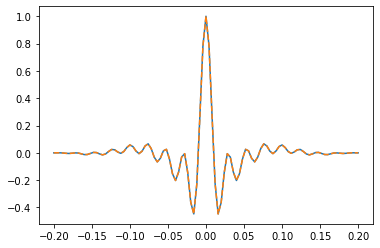

In [32]:
plt.plot(tw, orms)
plt.plot(tw2, orms2, '--')

This new result matches the figure:

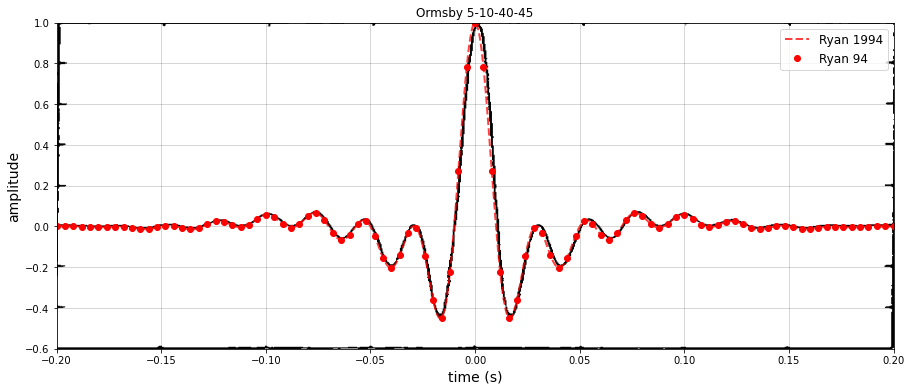

In [33]:
fig, ax = plt.subplots(figsize=(15, 6), facecolor='white')

# Show the background plot.
img = plt.imread('Ormsby_wavelet_data-area.png')
ax.imshow(img, extent=[-0.2, 0.2, -0.6, 1.0], aspect='auto')

# Plot the smoothed waveforms.
# ax.plot(*smoothify(tw, orms), 'g', lw=3, alpha=0.75, label='Bruges')
ax.plot(*smoothify(tw2, orms2), 'r--', lw=2, alpha=0.75, label='Ryan 1994')

# Plot the points we computed.
# ax.plot(tw, orms, 'bo', label='Bruges')
ax.plot(tw2, orms2, 'ro', label='Ryan 94')

# Trimmings.
ax.legend(loc=1, fontsize=12)
ax.set_xlim(-0.2,0.2)
ax.set_ylim(-0.6, 1.0)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_title("Ormsby {}-{}-{}-{}".format(*freqs))
ax.grid(c='k', alpha=0.2)

plt.show()

## Montclair State University

<img src="https://e4c0a355-a-62cb3a1a-s-sites.googlegroups.com/site/cwilshusenreu2012/research-updates/Ormsby%20Formula.jpg?attachauth=ANoY7cpL27eSggLbPipqV0w4flIMetoCmc_M62THjRird3aNS_OCgiPCDwxR6jdjdgQZUnGYbPb_4qhpGJwengg6B9NZ7N5andasABNqxZbFTIk7XVbOiZq9d_RgZTJlATc_USrjFEz50F35BOmosfWuTjIVhC0N66Mohx4fan4sn2jvf1oIAhT1-d6xvW9wpM8SJD7S3XbTfRtkeZTGRMT_-KXlHl8B1OCTO1Ylt1GcZdAtAgkq87DU7ftCSM351dxqHIUfr_kL&attredirects=0" />

where

<img src="https://sites.google.com/site/cwilshusenreu2012/_/rsrc/1339519075367/research-updates/Ormsby%20IC.jpg?height=191&width=337" />

The result is roughly the right shape and frequency, but does not match the figure in Ryan.

In [34]:
def ormsby3(duration, dt, f, return_t=True):
    """
    Implementation from Montclair State University
    https://sites.google.com/site/cwilshusenreu2012/research-updates
    """
    t = np.arange(-duration/2, dt+duration/2, dt)  # Get 'extra' sample.
    f1, f2, f3, f4 = f

    c4 = np.pi * f4**2 / (f4 - f3)
    c3 = np.pi * f3**2 / (f4 - f3)
    c2 = np.pi * f2**2 / (f2 - f1)
    c1 = np.pi * f1**2 / (f2 - f1)
    mul = 1 / (c4 - c3 - c2 + c1)
    
    def part(c, f, t):
        return c * (np.sin(np.pi * f * t) / (np.pi * f * t))**2
        
    w = mul * (part(c4, f4, t) - part(c3, f3, t) - part(c2, f2, t) - part(c1, f1, t))

    w /= np.amax(w)
    return w, t

In [22]:
orms3, tw3 = ormsby3(0.4, dt=0.004, f=freqs, return_t=True)

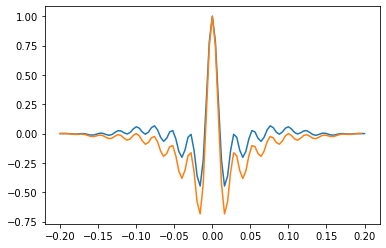

In [24]:
plt.plot(tw, orms)
plt.plot(tw3, orms3)

## `seismic.jl`

From here: http://seismicjulia.github.io/Seismic.jl/Wavelets/page1/

In [35]:
def ormsby4(duration, dt, f):
    """
    From seismic.jl
    """
    t = np.arange(-duration/2, dt+duration/2, dt)  # Get 'extra' sample.

    f1, f2, f3, f4 = f
        
    fc = (f2+f3)/2.0
    nw = 2.2/(fc*dt)
    nc = np.floor(nw/2)
    nw = 2*nc + 1
    a4 = (np.pi*f4)**2/(np.pi*(f4-f3))
    a3 = (np.pi*f3)**2/(np.pi*(f4-f3))
    a2 = (np.pi*f2)**2/(np.pi*(f2-f1))
    a1 = (np.pi*f1)**2/(np.pi*(f2-f1))

    u = a4*(np.sinc(f4*t))**2 - a3*(np.sinc(f3*t))**2
    v = a2*(np.sinc(f2*t))**2 - a1*(np.sinc(f1*t))**2

    w = u - v
    w = w*np.hamming(w.size)/np.max(w)
    return w, t

In [36]:
orms4, tw4 = ormsby4(0.4, dt=0.004, f=freqs)

The result matches the Ryan figure almost perfectly... apart from the application of the Hamming window. (Without that, it's the same wavelet.)

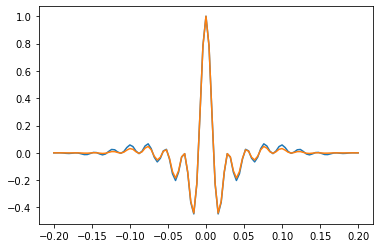

In [37]:
plt.plot(tw, orms)
plt.plot(tw4, orms4)

## KIT / GPIAG / SOFI2D

GPIAG / SOFI2D software from geophysical institut of the KIT (Karlsruhe Institute of Technology)

https://git.scc.kit.edu/GPIAG-Software/SOFI2D/blob/Release/mfiles/wavelet_gen.m

NB MATLAB also uses the extra pi term in the sinc function, so it should behave like NumPy.

In [41]:
def ormsby5(duration, dt, f):
    """
    Implementation from KIT.
    """
    fo1, fo2, fo3, fo4 = f

    t = np.arange(0, dt+duration, dt) - duration / 2

    tau1 = ((np.pi*fo4)**2)/((np.pi*fo4)-np.pi*fo3)
    tau2 = ((np.pi*fo3)**2)/((np.pi*fo4)-np.pi*fo3)
    tau3 = ((np.pi*fo2)**2)/((np.pi*fo2)-np.pi*fo1)
    tau4 = ((np.pi*fo1)**2)/((np.pi*fo2)-np.pi*fo1)

    # find sample point at which t-tshift is a minimum 
    minshift, ishift = 0, len(t)//2

    # calculate sinc function
    x = fo4*t   
    sinc1 = np.sin(np.pi*x)/(np.pi*x + 1e-9)
    sinc1[ishift] = 1.0

    x = fo3*t    
    sinc2 = np.sin(np.pi*x)/(np.pi*x + 1e-9)
    sinc2[ishift] = 1.0

    x = fo2*t  
    sinc3 = np.sin(np.pi*x)/(np.pi*x + 1e-9)
    sinc3[ishift] = 1.0

    x = fo1*t 
    sinc4 = np.sin(np.pi*x)/(np.pi*x + 1e-9)
    sinc4[ishift] = 1.0

    # calculate Ormsby signal
    ft = ((tau1 * sinc1**2) - (tau2 * sinc2**2)) - ((tau3 * sinc3**2) - (tau4 * sinc4**2))

    ft = ft / max(ft)
    
    return ft, t

In [42]:
orms5, tw5 = ormsby5(0.4, dt=0.004, f=freqs)

The result exactly matches the Ryan wavelet.

In [43]:
np.allclose(orms, orms5)

True

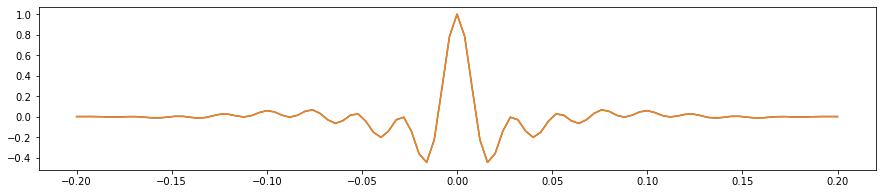

In [46]:
plt.figure(figsize=(15, 3))
plt.plot(tw, orms)
plt.plot(tw5, orms5)

## Comparison

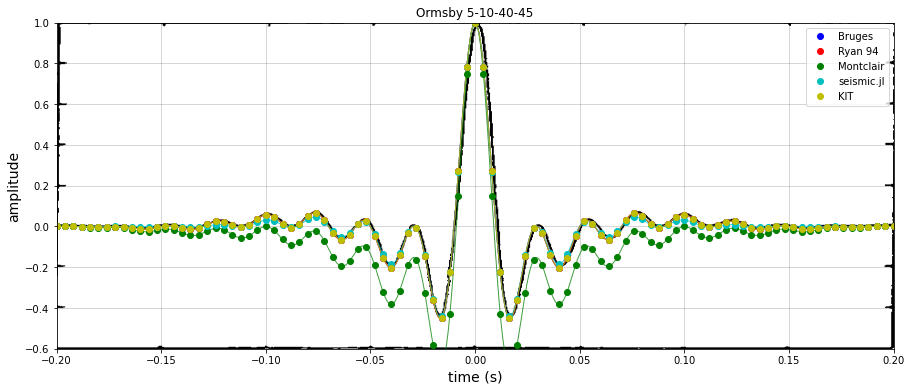

In [47]:
fig, ax = plt.subplots(figsize=(15, 6))

# Show the background plot.
img = plt.imread('Ormsby_wavelet_data-area.png')
ax.imshow(img, extent=[-0.2, 0.2, -0.6, 1.0], aspect='auto')

# Plot the smoothed waveforms.
ax.plot(*smoothify(tw, orms), 'b', lw=1, alpha=0.75)
ax.plot(*smoothify(tw2, orms2), 'r', lw=1, alpha=0.75)
ax.plot(*smoothify(tw3, orms3), 'g', lw=1, alpha=0.75)
ax.plot(*smoothify(tw4, orms4), 'c', lw=1, alpha=0.75)
ax.plot(*smoothify(tw5, orms5), 'y', lw=1, alpha=0.75)

# Plot the points.
ax.plot(tw, orms, 'bo', label='Bruges')
ax.plot(tw2, orms2, 'ro', label='Ryan 94')
ax.plot(tw3, orms3, 'go', label='Montclair')
ax.plot(tw4, orms4, 'co', label='seismic.jl')
ax.plot(tw5, orms5, 'yo', label='KIT')

# Trimmings.
ax.legend(loc=1)
ax.set_xlim(-0.2,0.2)
ax.set_ylim(-0.6, 1.0)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_title("Ormsby {}-{}-{}-{}".format(*freqs))
ax.grid(c='k', alpha=0.2)

plt.show()


## Miong & Stewart 2007

Soo-Kyung Miong, Robert R. Stewart and Joe Wong, Characterizing the near surface with VSP and well logs, CREWES Research Report — Volume 19 (2007).

The authors do not give an implementation, but I digitized the Ormsby wavelet in their figure 7 using https://automeris.io/WebPlotDigitizer/

In [48]:
miong = np.array([[-0.0385086,-0.0024259],
[-0.0317604,-0.0040431],
[-0.0267726,-0.0040431],
[-0.0215501,-0.0040431],
[-0.0193203,-0.0072776],
[-0.0180880,-0.0040431],
[-0.0162103,-0.0072776],
[-0.0148020,-0.0032345],
[-0.0135110,-0.0097035],
[-0.0123961,-0.0040431],
[-0.0116919,-0.0040431],
[-0.0103716,-0.0129380],
[-0.0089340,0.0000000],
[-0.0074670,-0.0177898],
[-0.0068215,-0.0056604],
[-0.0061174,0.0080863],
[-0.0049438,-0.0307278],
[-0.0042983,-0.0137466],
[-0.0034768,0.0291105],
[-0.0019511,-0.0800539],
[-0.0013056,-0.0129380],
[-0.0003667,0.3000000],
[0.0003961,0.3000000],
[0.0014523,-0.0226415],
[0.0019804,-0.0808625],
[0.0028606,0.0048518],
[0.0034474,0.0299191],
[0.0045037,-0.0266846],
[0.0052078,-0.0185984],
[0.0061467,0.0080863],
[0.0069095,-0.0048518],
[0.0074963,-0.0177898],
[0.0089633,0.0000000],
[0.0103716,-0.0129380],
[0.0114279,-0.0048518],
[0.0125428,-0.0048518],
[0.0134230,-0.0097035],
[0.0147139,-0.0040431],
[0.0162396,-0.0072776],
[0.0179413,-0.0040431],
[0.0192323,-0.0072776],
[0.0208753,-0.0040431],
[0.0253936,-0.0040431],
[0.0306161,-0.0040431],
[0.0345477,-0.0024259],
[0.0389487,-0.0024259]])

In [49]:
t6, w6 = smoothify(*miong.T)

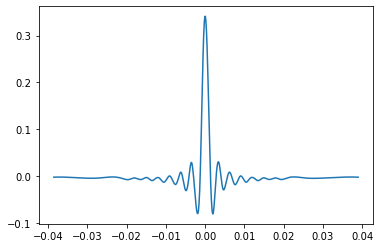

In [50]:
plt.plot(t6, w6)

The authors don't give the parameters of this wavelet, so let's try to match it.

/Users/matt/opt/miniconda3/envs/py39/lib/python3.9/site-packages/bruges/filters/wavelets.py:425: FutureWarning: In future releases, the default legacy behaviour will be removed. We recommend setting sym=True. This will be the default in v0.5+.
  t = _get_time(duration, dt, sym=sym)


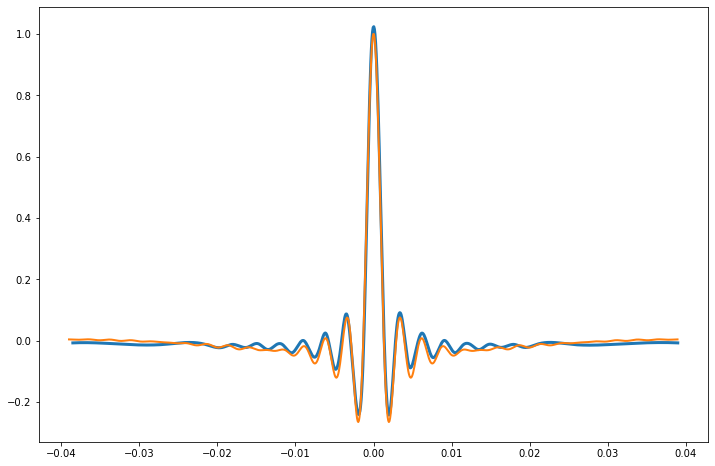

In [51]:
orms0, tw0 = ormsby(0.078, dt=0.00008, f=[8, 24, 325, 400], return_t=True)

plt.figure(figsize=(12, 8))
plt.plot(t6, 3*w6, lw=3)
plt.plot(tw0, orms0, lw=2)

So it might be a reasonable implementation, although this particular wavelet is very high bandwidth, but we can't know for sure. 

## Petrel

See comments in Software Underground: https://swung.slack.com/archives/C094GV18T/p1612860192157300

Long story short: they seem to apply a triangular taper, a bit like what `seismic.jl` does with the Hamming.

## Check spectrums

Check the spectrums of the wavelets:

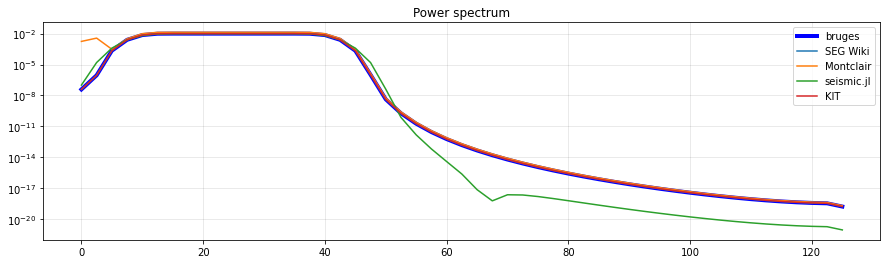

In [52]:
from scipy.signal import welch

plt.figure(figsize=(15, 4))

plt.semilogy(*welch(orms, fs=250, nperseg=100, scaling='spectrum'), c='b', lw=4, label='bruges')
plt.semilogy(*welch(orms2, fs=250, nperseg=100, scaling='spectrum'), label='SEG Wiki')
plt.semilogy(*welch(orms3, fs=250, nperseg=100, scaling='spectrum'), label='Montclair')
plt.semilogy(*welch(orms4, fs=250, nperseg=100, scaling='spectrum'), label='seismic.jl')
plt.semilogy(*welch(orms5, fs=250, nperseg=100, scaling='spectrum'), label='KIT')
plt.legend()
plt.grid(c='k', alpha=0.1)
plt.title('Power spectrum')
plt.show()

Let's just compare an Ormsby to a Ricker:

/Users/matt/opt/miniconda3/envs/py39/lib/python3.9/site-packages/bruges/filters/wavelets.py:272: FutureWarning: In future releases, the default legacy behaviour will be removed. We recommend setting sym=True. This will be the default in v0.5+.
  t = _get_time(duration, dt, sym=sym)


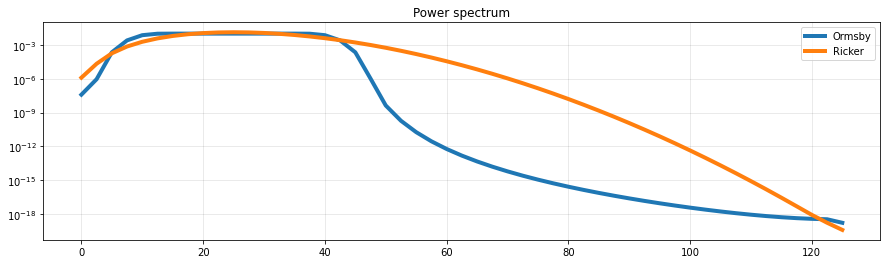

In [53]:
from bruges.filters import ricker

rick, tw = ricker(0.4, dt=0.004, f=25, return_t=True)

plt.figure(figsize=(15, 4))
plt.semilogy(*welch(orms, fs=250, nperseg=100, scaling='spectrum'), c='C0', lw=4, label='Ormsby')
plt.semilogy(*welch(rick, fs=250, nperseg=100, scaling='spectrum'), c='C1', lw=4, label='Ricker')
plt.legend()
plt.grid(c='k', alpha=0.1)
plt.title('Power spectrum')
plt.show()

/Users/matt/opt/miniconda3/envs/py39/lib/python3.9/site-packages/bruges/filters/wavelets.py:272: FutureWarning: In future releases, the default legacy behaviour will be removed. We recommend setting sym=True. This will be the default in v0.5+.
  t = _get_time(duration, dt, sym=sym)


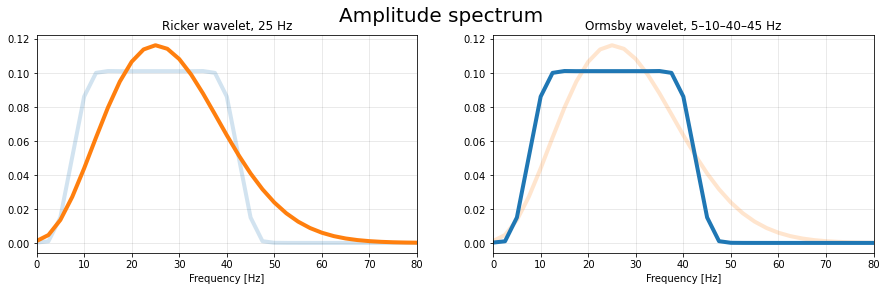

In [54]:
from bruges.filters import ricker

rick, tw = ricker(0.4, dt=0.004, f=25, return_t=True)

f, Pxx_orms = welch(orms, fs=250, nperseg=100, scaling='spectrum')
_, Pxx_rick = welch(rick, fs=250, nperseg=100, scaling='spectrum')


fig, axs = plt.subplots(ncols=2, figsize=(15, 4), facecolor='white')

ax = axs[0]
ax.plot(f, np.sqrt(Pxx_orms), c='C0', lw=4, label='Ormsby', alpha=0.2)
ax.plot(f, np.sqrt(Pxx_rick), c='C1', lw=4, label='Ricker')
ax.set_title('Ricker wavelet, 25 Hz')
ax.set_xlim(0, 80)
ax.set_xlabel('Frequency [Hz]')
ax.grid(c='k', alpha=0.1)

ax = axs[1]
ax.plot(f, np.sqrt(Pxx_rick), c='C1', lw=4, label='Ricker', alpha=0.2)
ax.plot(f, np.sqrt(Pxx_orms), c='C0', lw=4, label='Ormsby')
ax.set_title('Ormsby wavelet, 5–10–40–45 Hz')
ax.set_xlim(0, 80)
ax.set_xlabel('Frequency [Hz]')
ax.grid(c='k', alpha=0.1)

plt.suptitle('Amplitude spectrum', size=20)
plt.show()

I wrote about this in [What is an Ormsby anyway?](https://agilescientific.com/blog/2021/2/9/what-is-an-ormsby-wavelet-anyway).

----

## More wavelet stuff

- https://onlinelibrary.wiley.com/doi/abs/10.1111/1365-2478.12407
- https://pubs.geoscienceworld.org/interpretation/article-abstract/5/4/T523/520500/Accuracy-of-wavelets-seismic-inversion-and-thin?redirectedFrom=PDF
- http://www.geophysical-press.com/online/VOL28-4_art5.pdf
- https://link.springer.com/article/10.1007/s13202-019-00748-9
- https://www.crewes.org/ForOurSponsors/ResearchReports/2014/CRR201418.pdf

<hr>

<center><img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" width="50px"></center>

<br>

<center><span style="color:gray;">Code and text © 2021 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;</span></center>